<a href="https://colab.research.google.com/github/Tsyshnatiy/PerfUnitTests/blob/main/PerfUnitTestsAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Performance unit testing on Google Benchmark

## What this talk is about?

# Goal

#### A tool for detecting single algorithm performance regression.

## Google benchmark primer + let's play

```
static void BM_vector_push_back(benchmark::State& state) {
  for (auto _ : state) {
    std::vector<int> v;
    v.reserve(1);
    auto data = v.data();           // Allow v.data() to be clobbered. Pass as non-const
    benchmark::DoNotOptimize(data); // lvalue to avoid undesired compiler optimizations
    v.push_back(42);
    benchmark::ClobberMemory(); // Force 42 to be written to memory.
  }
}

BENCHMARK(BM_vector_push_back);

BENCHMARK_MAIN();
```

## Problem Formulation

* Benchmark results != tests
* Performance measurement depends on multiple variables and even production quality frameworks produce noisy results

## Benchmark results != tests

```
./run_benchmarks.x --benchmark_filter=BM_memcpy/32
Run on (1 X 2300 MHz CPU )
2016-06-25 19:34:24
Benchmark              Time           CPU Iterations
----------------------------------------------------
BM_memcpy/32          11 ns         11 ns   79545455
BM_memcpy/32k       2181 ns       2185 ns     324074
BM_memcpy/32          12 ns         12 ns   54687500
BM_memcpy/32k       1834 ns       1837 ns     357143
```

VS

```
[ RUN      ] MyTest.Fuzz
[       OK ] MyTest.Fuzz (1867 ms)
```

## What is missing?

https://github.com/google/benchmark/blob/main/docs/tools.md

```
Benchmark                 Time             CPU      Time Old      Time New       CPU Old       CPU New
------------------------------------------------------------------------------------------------------
BM_memcpy/8            +0.0020         +0.0020            36            36            36            36
BM_memcpy/64           -0.0468         -0.0470            76            73            76            73
BM_memcpy/512          +0.0081         +0.0083            84            85            84            85
BM_memcpy/1024         +0.0098         +0.0097           116           118           116           118
BM_memcpy/8192         +0.0200         +0.0203           643           656           643           656
BM_copy/8              +0.0046         +0.0042           222           223           222           223
BM_copy/64             +0.0020         +0.0020          1608          1611          1608          1611
BM_copy/512            +0.0027         +0.0026         12589         12622         12589         12622
BM_copy/1024           +0.0035         +0.0028         25169         25257         25169         25239
BM_copy/8192           +0.0191         +0.0194        201165        205013        201112        205010
```

### U test

If there is a sufficient repetition count of the benchmarks, the tool can do a U Test, of the null hypothesis that it is equally likely that a randomly selected value from one sample will be less than or greater than a randomly selected value from a second sample.

If the calculated p-value is below this value is lower than the significance level alpha, then the result is said to be statistically significant and the null hypothesis is rejected. Which in other words means that the two benchmarks aren't identical.

WARNING: requires LARGE (no less than 9) number of repetitions to be meaningful!

https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test

##Performance measurement depends on multiple variables

## Math primer

![image](https://kierandixon.com/wp-content/uploads/population-standard-deviation-equation.png)

![image](https://radioprog.ru/uploads/media/articles/0001/05/b5fcfc0c669d6b47ffcf5d0d26e3f821884e1f69.jpeg)

### Demonstration

In [5]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

sns.set()

In [6]:
def plot(path, tests):
  df = pd.read_csv(path)
  df.drop(df[df.name.str.endswith("_mean")].index, inplace = True)
  df.drop(df[df.name.str.endswith("_median")].index, inplace = True)
  df.drop(df[df.name.str.endswith("_stddev")].index, inplace = True)
  df.drop(df[df.name.str.endswith("_cv")].index, inplace = True)

  figure, axes = plt.subplots(len(tests), 1, sharex=True, figsize=(10,20))
  figure.suptitle('Performance')

  for i in range(0, len(tests)):
    series = df.loc[df.name == tests[i]]
    minimum = series.cpu_time.min()
    maximum = series.cpu_time.max()
    mean = series.cpu_time.mean()
    stddev = series.cpu_time.std()
    series.loc[:, "cpu_time"] -= mean

    x = np.arange(1, series.shape[0] + 1)

    axes[i].set_title(f"{tests[i]} stddev = {stddev / mean}")
    sns.barplot(ax=axes[i], data=series, x=x, y="cpu_time")

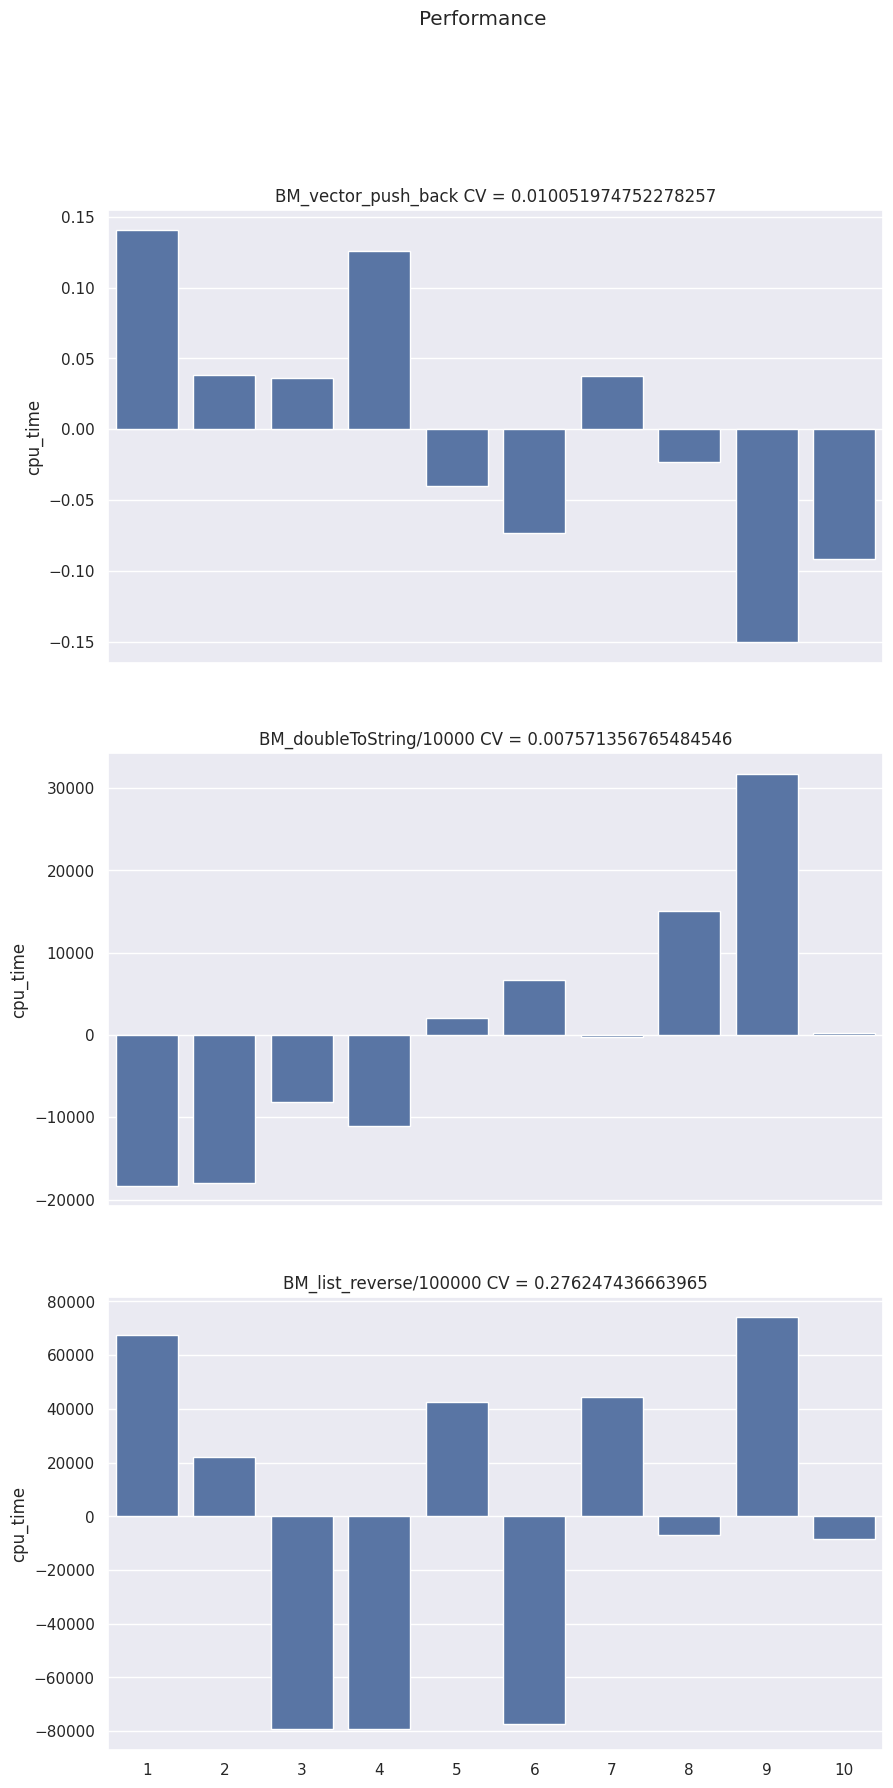

In [7]:
tests = ["BM_vector_push_back",
         "BM_doubleToString/10000",
         "BM_list_reverse/100000"]
plot("sample_data/no_tuning.csv", tests)

In [8]:
# sudo cpupower frequency-set --governor performance

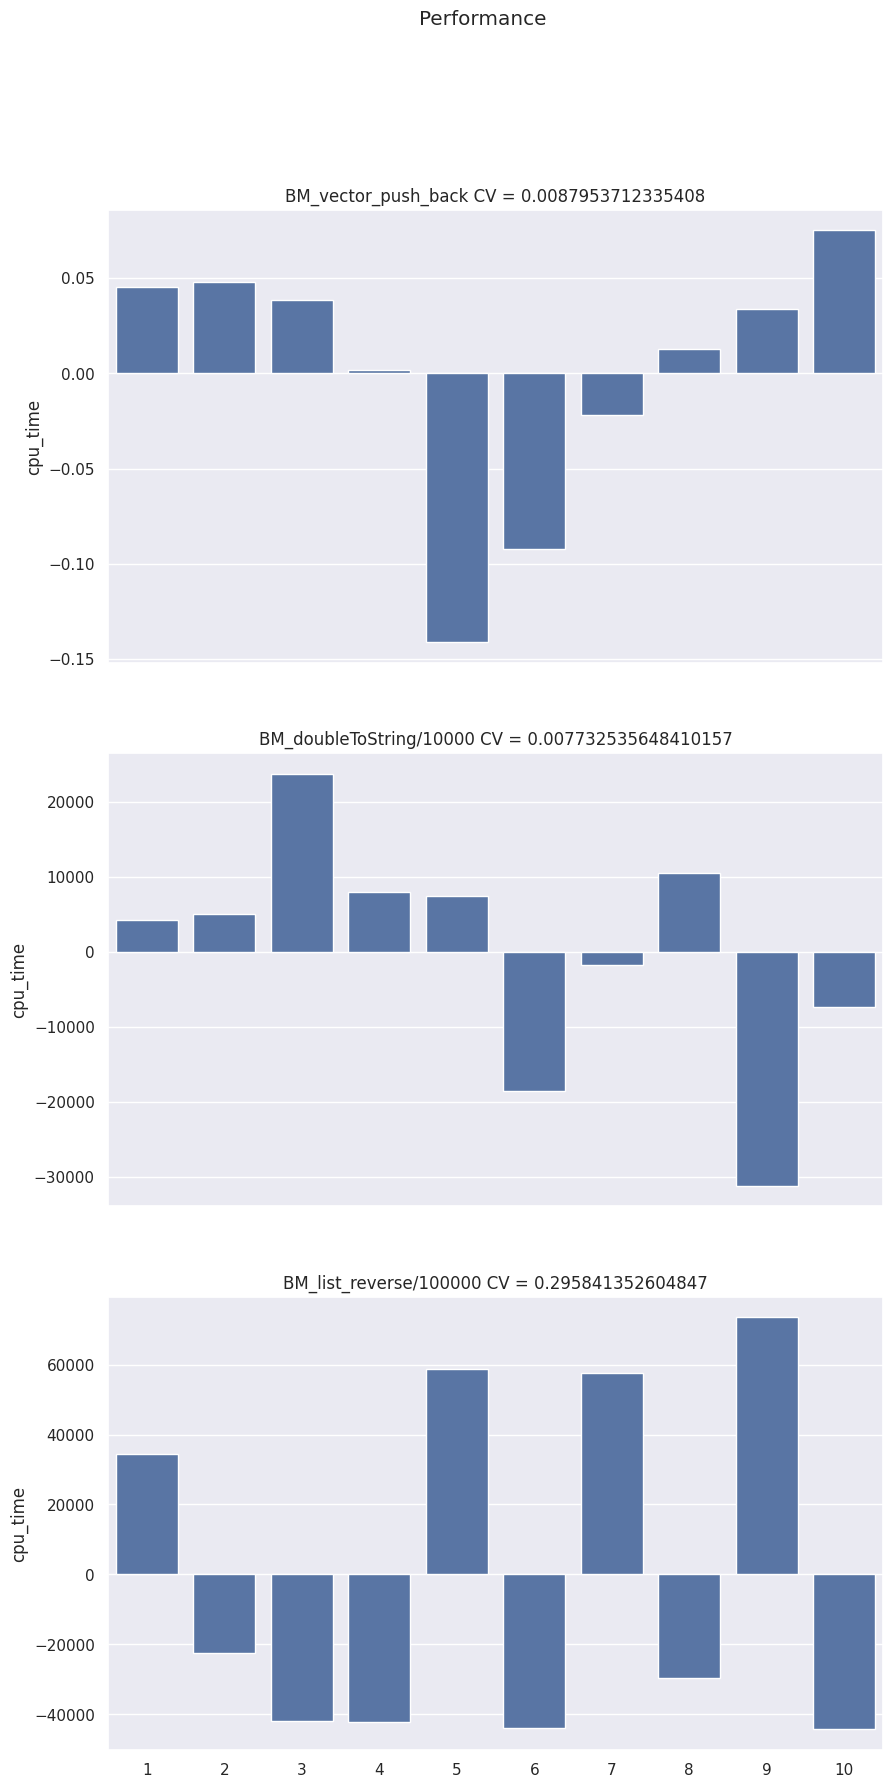

In [9]:
plot("sample_data/governor_performance.csv", tests)

In [10]:
# /etc/default/grub > GRUB_CMDLINE_LINUX="isolcpus=5,11 nohz_full=0,2"
# sudo update-grub
# Reboot
# cat /sys/devices/system/cpu/isolated
# taskset -c 0,2 ./GB_PerfUnitTests --benchmark_repetitions=10

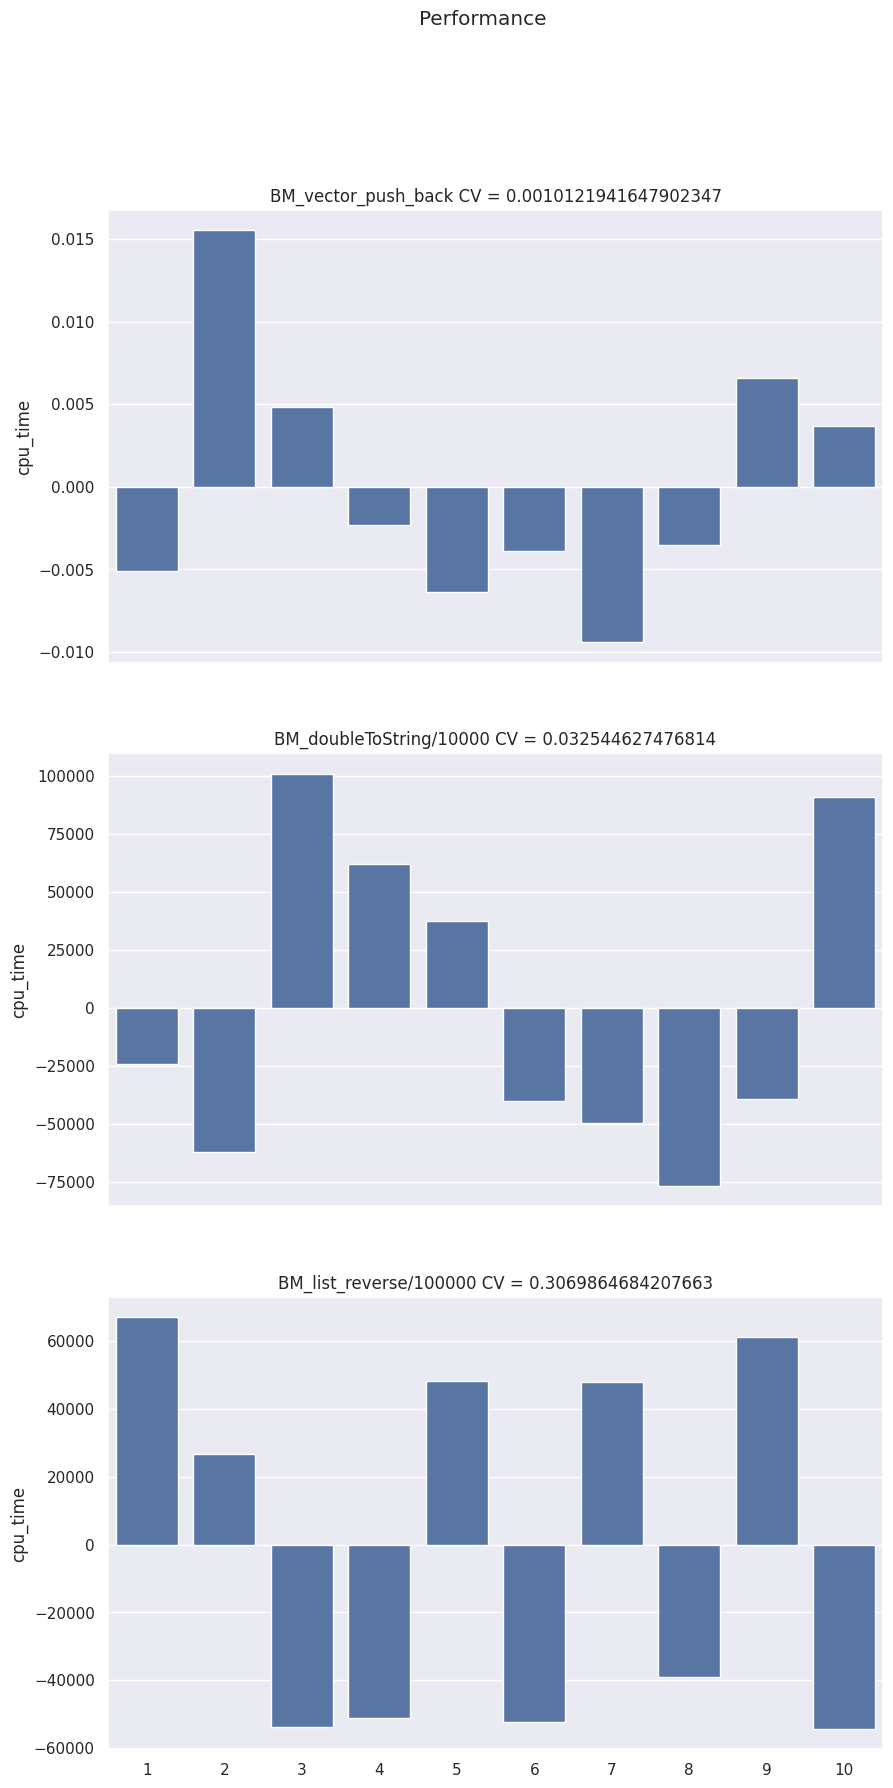

In [11]:
plot("sample_data/isolated_cpus.csv", tests)

In [12]:
# sudo -s echo off > /sys/devices/system/cpu/smt/control

# sudo bash -c "echo 2000000 > /sys/devices/system/cpu/cpu0/cpufreq/scaling_min_freq"
# sudo bash -c "echo 2000000 > /sys/devices/system/cpu/cpu0/cpufreq/scaling_max_freq"
# sudo bash -c "echo 2000000 > /sys/devices/system/cpu/cpu2/cpufreq/scaling_min_freq"
# sudo bash -c "echo 2000000 > /sys/devices/system/cpu/cpu2/cpufreq/scaling_max_freq"

# watch -n.1 "grep \"^[c]pu MHz\" /proc/cpuinfo"

# taskset -c 0,2 ./GB_PerfUnitTests --benchmark_repetitions=10

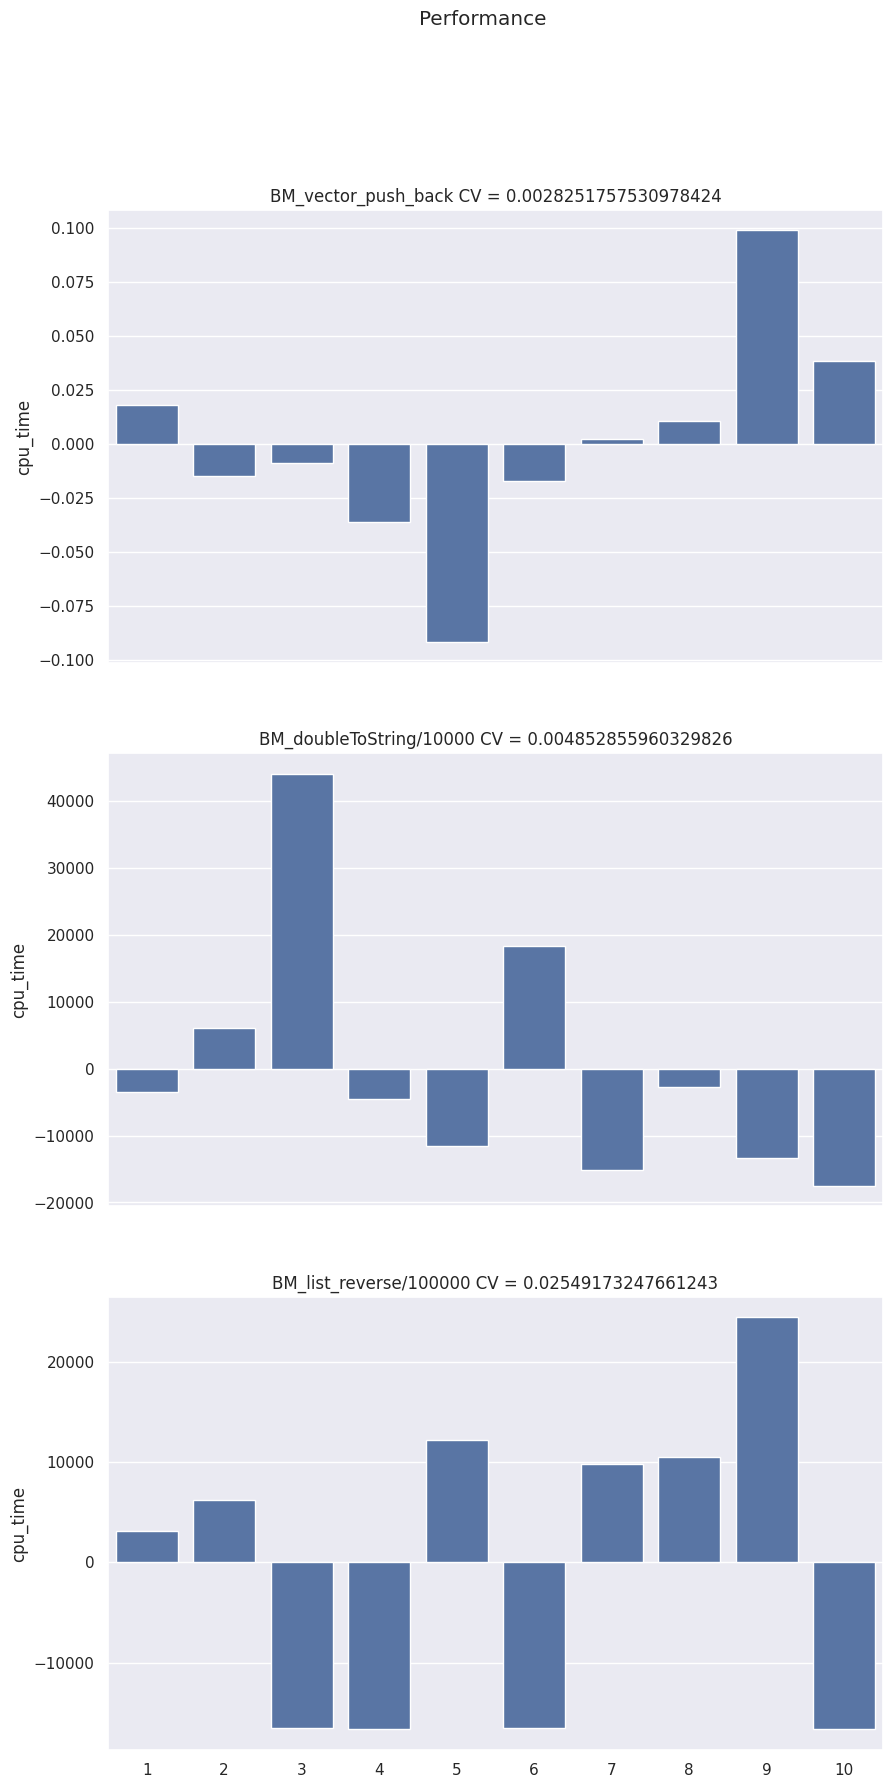

In [13]:
plot("sample_data/freq_2000.csv", tests)

### Typical benchmark noise sources

    Compiler optimizations

    CPU and memory cache.

    A benchmark is executed on different CPU cores or a core switches to another process

    Network requests

    IO operations

    Heap allocations are not always have equal performance

    CPU can choose to run on another frequency
  
    Hyperthreading enabled

    Running benchmarks on VM

    Non isolated environment

Additional recommendations

    Consider performance tests failed if they fail hard or fail at least twice in sequence.

    Use Voting of different benchmark frameworks to decide if test failed.
    
    Reboot before every performance test run. This will approximate a same start conditions for consequitive runs.

    Do low pass filtering to reduce stddev


## What about another approach?

### Math primer: What is Least Squares Error method
![image](https://upload.wikimedia.org/wikipedia/commons/thumb/e/e3/Linear_least_squares2.svg/1200px-Linear_least_squares2.svg.png)

## Google benchmark primer + let's play 2

```
static void BM_ListReverse(benchmark::State& state) {
  std::list<int> l;
  for (int i = 0 ; i < state.range(0) ; ++i) {
    l.push_front(i);
  }

  for (auto _ : state) {
    l.reverse();
    benchmark::DoNotOptimize(l);
    benchmark::ClobberMemory();
  }

  state.SetComplexityN(state.range(0));
}

BENCHMARK(BM_ListReverse)
    ->RangeMultiplier(2)->Range(1<<10, 1<<18)->Complexity(benchmark::oN);


BENCHMARK_MAIN();
```

## Output from untuned machine



```
-------------------------------------------------------------------
Benchmark                         Time             CPU   Iterations
-------------------------------------------------------------------
BM_StringCompare_BigO          0.02 N          0.02 N    
BM_StringCompare_RMS              4 %             4 %    
...
BM_BinarySearch_BigO           0.45 lgN        0.45 lgN  
BM_BinarySearch_RMS               4 %             4 %    
...
BM_ListReverse_BigO            1.84 N          1.84 N    
BM_ListReverse_RMS               16 %            16 %    

...

-------------------------------------------------------------------
Benchmark                         Time             CPU   Iterations
-------------------------------------------------------------------
BM_StringCompare_BigO          0.02 N          0.02 N    
BM_StringCompare_RMS              4 %             4 %    
...
BM_BinarySearch_BigO           0.46 lgN        0.46 lgN  
BM_BinarySearch_RMS               4 %             4 %    
...
BM_ListReverse_BigO            1.96 N          1.96 N    
BM_ListReverse_RMS               19 %            19 %    

...

--------------------------------------------------------------------------
Benchmark                                Time             CPU   Iterations
--------------------------------------------------------------------------
...
BM_StringCompare_BigO                 0.02 N          0.02 N    
BM_StringCompare_RMS                     5 %             5 %    
...
BM_BinarySearch_BigO                  0.47 lgN        0.47 lgN  
BM_BinarySearch_RMS                      5 %             5 %    
...
BM_ListReverse_BigO                   1.25 N          1.25 N    
BM_ListReverse_RMS                      44 %            44 %
```



### What does it mean to fail a test?

### Expected logN but measured N
```
for (auto _ : state) {
  auto it = std::find(std::begin(v), std::end(v), state.range(0) / 3);
  benchmark::DoNotOptimize(v);
  benchmark::DoNotOptimize(it);
  benchmark::ClobberMemory();
}

BENCHMARK(BM_Search)
    ->RangeMultiplier(2)->Range(1<<18, 1<<24)->Complexity(benchmark::oLogN);

BM_Search_BigO       13082.42 lgN    13080.61 lgN  
BM_Search_RMS             128 %           128 %    
```


  